In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import requests

In [2]:
# Chargement des données
response = requests.get("https://portail-api-data.montpellier3m.fr/ecocounter?limit=1000")
print(response.json())

res = requests.get("https://portail-api-data.montpellier3m.fr/ecocounter_timeseries/urn%3Angsi-ld%3AEcoCounter%3ACOM23120110/attrs/intensity?fromDate=2025-11-22T00%3A00%3A00&toDate=2025-11-24T00%3A00%3A00")
print(res.json())

[{'id': 'urn:ngsi-ld:EcoCounter:XTH19101158', 'type': 'EcoCounter', 'deviceType': {'type': 'Text', 'value': 'TrafficFlowObserved', 'metadata': {}}, 'intensity': {'type': 'Number', 'value': 4, 'metadata': {'TimeInstant': {'type': 'DateTime', 'value': '2025-11-28T04:00:00.000Z'}}}, 'laneId': {'type': 'Number', 'value': 188609530, 'metadata': {}}, 'location': {'type': 'geo:json', 'value': {'type': 'Point', 'coordinates': [43.61621, 3.874408]}, 'metadata': {}}, 'reversedLane': {'type': 'Boolean', 'value': False, 'metadata': {}}, 'vehicleType': {'type': 'Text', 'value': 'bicycle', 'metadata': {}}}, {'id': 'urn:ngsi-ld:EcoCounter:X2H22104775', 'type': 'EcoCounter', 'deviceType': {'type': 'Text', 'value': 'TrafficFlowObserved', 'metadata': {}}, 'intensity': {'type': 'Number', 'value': 0, 'metadata': {'TimeInstant': {'type': 'DateTime', 'value': '2025-11-28T03:00:00.000Z'}}}, 'laneId': {'type': 'Number', 'value': 8584788, 'metadata': {}}, 'location': {'type': 'geo:json', 'value': {'type': 'Poi

In [3]:
df_api = pd.json_normalize(res.json())
print(df_api.head())

df_counters= pd.json_normalize(response.json())
print(df_counters.head())


    attrName                            entityId  entityType  \
0  intensity  urn:ngsi-ld:EcoCounter:COM23120110  EcoCounter   

                                               index  \
0  [2025-11-22T00:00:00.000+00:00, 2025-11-22T01:...   

                                              values  
0  [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...  
                                   id        type deviceType.type  \
0  urn:ngsi-ld:EcoCounter:XTH19101158  EcoCounter            Text   
1  urn:ngsi-ld:EcoCounter:X2H22104775  EcoCounter            Text   
2  urn:ngsi-ld:EcoCounter:X2H20042632  EcoCounter            Text   
3  urn:ngsi-ld:EcoCounter:X2H20063164  EcoCounter            Text   
4  urn:ngsi-ld:EcoCounter:X2H19070220  EcoCounter            Text   

      deviceType.value intensity.type  intensity.value  \
0  TrafficFlowObserved         Number                4   
1  TrafficFlowObserved         Number                0   
2  TrafficFlowObserved         Number                0   
3

In [4]:
# Tri des données du plus ancien au récent
df_counters = df_counters.sort_values("intensity.metadata.TimeInstant.value").reset_index(drop=True)

df_counters = df_counters[[
    "id",
    "location.value.coordinates"
]].copy()

df_counters.columns = ["id", "coordinates"]
print(df_counters)

                                    id             coordinates
0   urn:ngsi-ld:EcoCounter:X2H20063164  [43.626698, 3.8956287]
1   urn:ngsi-ld:EcoCounter:X2H21070351    [43.58435, 3.907998]
2   urn:ngsi-ld:EcoCounter:X2H21070348   [43.610302, 3.913589]
3   urn:ngsi-ld:EcoCounter:X2H20063161   [43.61574, 3.9096322]
4   urn:ngsi-ld:EcoCounter:XTH21070328   [43.660053, 3.900942]
..                                 ...                     ...
68  urn:ngsi-ld:EcoCounter:X2H22043034      [43.60381, 3.8677]
69  urn:ngsi-ld:EcoCounter:X2H20042634     [43.57926, 3.93327]
70  urn:ngsi-ld:EcoCounter:X2H22043035     [43.60383, 3.86779]
71  urn:ngsi-ld:EcoCounter:X2H22104769       [43.5754, 3.8617]
72  urn:ngsi-ld:EcoCounter:XTH19101158    [43.61621, 3.874408]

[73 rows x 2 columns]


In [5]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def fetch_timeseries(counter_id, start_date, end_date):
    url = f"https://portail-api-data.montpellier3m.fr/ecocounter_timeseries/{counter_id}/attrs/intensity"

    params = {
        "fromDate": start_date,
        "toDate": end_date
    }

    r = requests.get(url, params=params)
    data = r.json()
    # Index = timestamps et values = l iste des valeurs horaires
    if "index" not in data or "values" not in data:
        return pd.DataFrame()
    
        # Construiction du dataframe
    df= pd.DataFrame({
        "time": pd.to_datetime(data["index"]),
        "value": data["values"]    
    })
    
    # Ajout de la colonne des identifiant compteur
    df["id"] = counter_id

    return df


def build_timeseries(df_counters, start_date, end_date):
    dfs = []
    for _, row in df_counters.iterrows():
        counter_id = row["id"]
        coords = row["coordinates"]

        df_ts = fetch_timeseries(counter_id, start_date, end_date)

        if df_ts.empty:
            continue

        df_ts["coordinates"] = [tuple(coords)] * len(df_ts)
        dfs.append(df_ts)
    
    if dfs:
        return pd.concat(dfs, ignore_index = True)
    else:
        return pd.DataFrame()


In [6]:
df_brut = build_timeseries(df_counters, start_date="2022-01-01T00:00:00", end_date ="2025-11-25T00:00:00")

df_brut

,time,value,id,coordinates
0,2023-01-01 00:00:00+00:00,2.0,urn:ngsi-ld:EcoCounter:X2H20063164,"(43.626698, 3.8956287)"
1,2023-01-01 01:00:00+00:00,0.0,urn:ngsi-ld:EcoCounter:X2H20063164,"(43.626698, 3.8956287)"
2,2023-01-01 02:00:00+00:00,0.0,urn:ngsi-ld:EcoCounter:X2H20063164,"(43.626698, 3.8956287)"
3,2023-01-01 03:00:00+00:00,1.0,urn:ngsi-ld:EcoCounter:X2H20063164,"(43.626698, 3.8956287)"
4,2023-01-01 04:00:00+00:00,2.0,urn:ngsi-ld:EcoCounter:X2H20063164,"(43.626698, 3.8956287)"
...,...,...,...,...
641166,2024-02-22 21:00:00+00:00,0.0,urn:ngsi-ld:EcoCounter:XTH19101158,"(43.61621, 3.874408)"
641167,2024-02-22 22:00:00+00:00,0.0,urn:ngsi-ld:EcoCounter:XTH19101158,"(43.61621, 3.874408)"
641168,2024-02-22 23:00:00+00:00,0.0,urn:ngsi-ld:EcoCounter:XTH19101158,"(43.61621, 3.874408)"
641169,2024-02-23 00:00:00+00:00,0.0,urn:ngsi-ld:EcoCounter:XTH19101158,"(43.61621, 3.874408)"


In [7]:
# Statistique des données
print(df_brut.describe())

# détection des valeurs manquantes
print("Les valeurs manquantes:", df_brut.isnull().sum())

              value
count  641171.00000
mean       21.51002
std        38.21344
min         0.00000
25%         1.00000
50%         7.00000
75%        25.00000
max       512.00000
Les valeurs manquantes: time           0
value          0
id             0
coordinates    0
dtype: int64


In [8]:
# Vérifaication des type de données
df_brut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641171 entries, 0 to 641170
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   time         641171 non-null  datetime64[ns, UTC]
 1   value        641171 non-null  float64            
 2   id           641171 non-null  object             
 3   coordinates  641171 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(2)
memory usage: 19.6+ MB


In [9]:
# Détection des doublons
duplicate = df_brut[df_brut.duplicated()]
print("Nombre de doublon:", duplicate)

# Suppresion des doublons
df_brut = df_brut.drop_duplicates()
print("Nombre de doublons restant:", df_brut)


Nombre de doublon:                             time  value                                  id  \
1249   2023-02-22 01:00:00+00:00    0.0  urn:ngsi-ld:EcoCounter:X2H20063164   
1251   2023-02-22 02:00:00+00:00    0.0  urn:ngsi-ld:EcoCounter:X2H20063164   
1253   2023-02-22 03:00:00+00:00    0.0  urn:ngsi-ld:EcoCounter:X2H20063164   
1255   2023-02-22 04:00:00+00:00    1.0  urn:ngsi-ld:EcoCounter:X2H20063164   
1257   2023-02-22 05:00:00+00:00    0.0  urn:ngsi-ld:EcoCounter:X2H20063164   
...                          ...    ...                                 ...   
641145 2023-11-14 04:00:00+00:00    0.0  urn:ngsi-ld:EcoCounter:XTH19101158   
641146 2023-11-14 04:00:00+00:00    0.0  urn:ngsi-ld:EcoCounter:XTH19101158   
641147 2023-11-14 04:00:00+00:00    0.0  urn:ngsi-ld:EcoCounter:XTH19101158   
641148 2023-11-14 04:00:00+00:00    0.0  urn:ngsi-ld:EcoCounter:XTH19101158   
641149 2023-11-14 04:00:00+00:00    0.0  urn:ngsi-ld:EcoCounter:XTH19101158   

                   coordinates  

In [10]:
# Détection des valeurs aberrantes
df_brut = df_brut[df_brut["value"] >= 0]

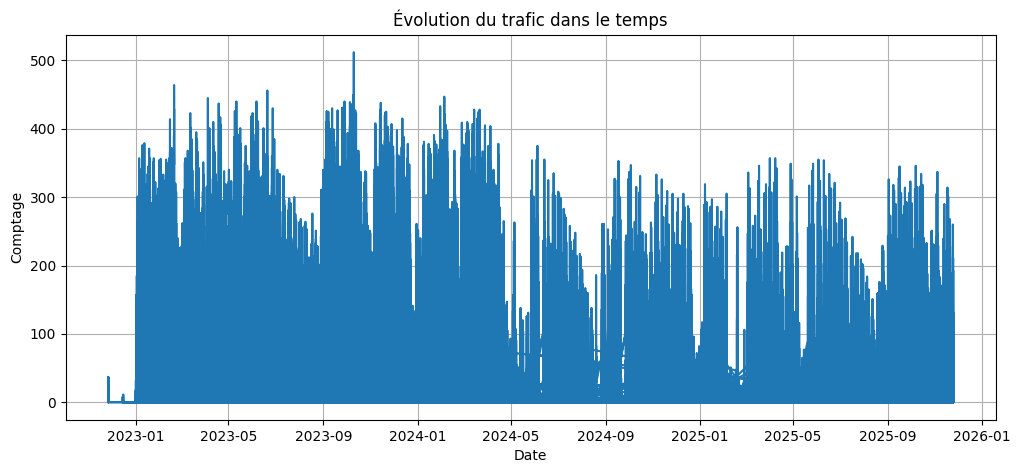

In [11]:
# Graphique sur l'evolution du trafic dans le temps
plt.figure(figsize=(12,5))
plt.plot(df_brut["time"], df_brut["value"])
plt.title("Évolution du trafic dans le temps")
plt.xlabel("Date")
plt.ylabel("Comptage")
plt.grid(True)
plt.show()


/tmp/ipykernel_2801/2422708584.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_traffic = df_brut.groupby("day_of_week")["value"].agg(["mean", "std"])


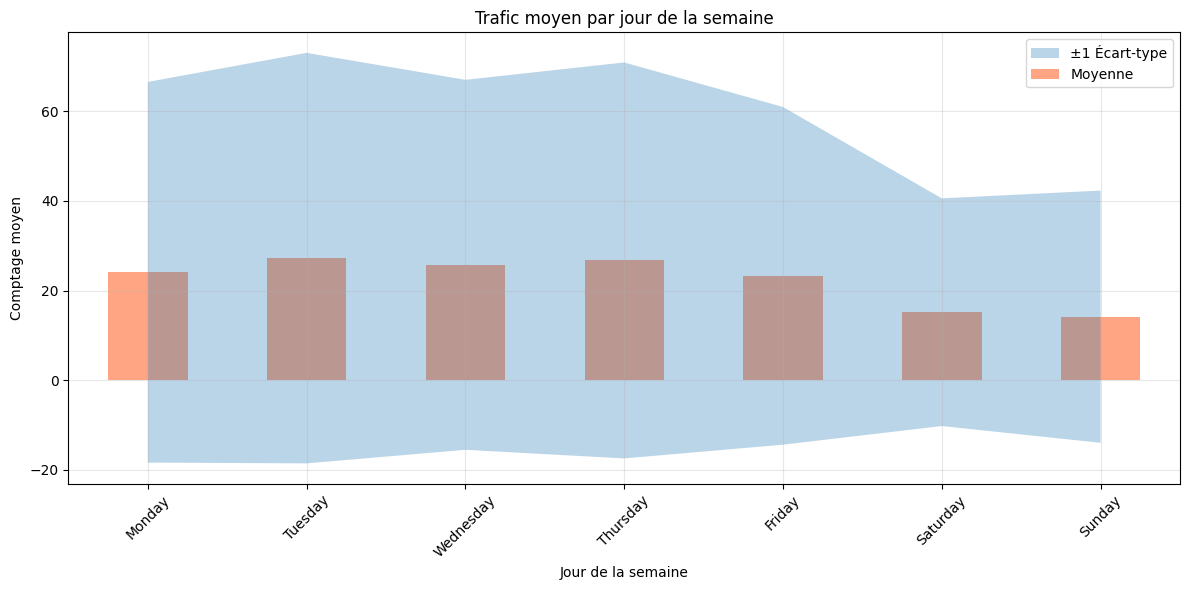

In [12]:
# Analyse par jour de la semaine
df_brut["day_of_week"] = df_brut["time"].dt.day_name()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_brut["day_of_week"] = pd.Categorical(df_brut["day_of_week"], categories=day_order, ordered=True)

fig, ax = plt.subplots(figsize=(12, 6))
daily_traffic = df_brut.groupby("day_of_week")["value"].agg(["mean", "std"])
daily_traffic["mean"].plot(kind="bar", ax=ax, color="coral", alpha=0.7, label="Moyenne")
ax.fill_between(range(len(daily_traffic)), 
                 daily_traffic["mean"] - daily_traffic["std"],
                 daily_traffic["mean"] + daily_traffic["std"],
                 alpha=0.3, label="±1 Écart-type")
ax.set_title("Trafic moyen par jour de la semaine")
ax.set_xlabel("Jour de la semaine")
ax.set_ylabel("Comptage moyen")
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

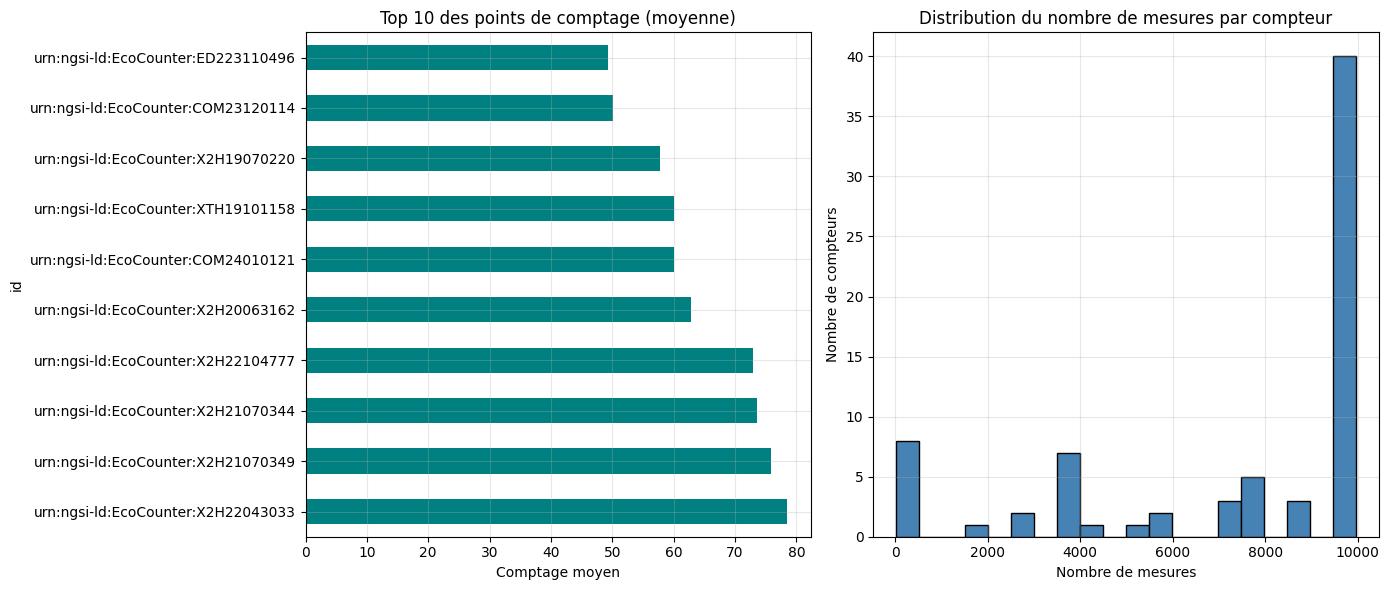


Statistiques par compteur:
            mean            sum        count
count  73.000000      73.000000    73.000000
mean   21.789323  163919.726027  7322.986301
std    20.394292  193230.008674  3454.252968
min     1.767797      44.000000    19.000000
25%     7.933333   34132.000000  4308.000000
50%    14.367982   97171.000000  9732.000000
75%    29.434765  199535.000000  9863.000000
max    78.506236  767948.000000  9965.000000


In [13]:
# Analyse par point de comptage (localisation)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Comptage par ID de compteur
traffic_by_counter = df_brut.groupby("id")["value"].agg(["mean", "sum", "count"])
traffic_by_counter.sort_values("mean", ascending=False).head(10)["mean"].plot(kind="barh", ax=axes[0], color="teal")
axes[0].set_title("Top 10 des points de comptage (moyenne)")
axes[0].set_xlabel("Comptage moyen")
axes[0].grid(True, alpha=0.3)

# Distribution du nombre de mesures par compteur
traffic_by_counter["count"].plot(kind="hist", ax=axes[1], bins=20, color="steelblue", edgecolor="black")
axes[1].set_title("Distribution du nombre de mesures par compteur")
axes[1].set_xlabel("Nombre de mesures")
axes[1].set_ylabel("Nombre de compteurs")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStatistiques par compteur:")
print(traffic_by_counter.describe())

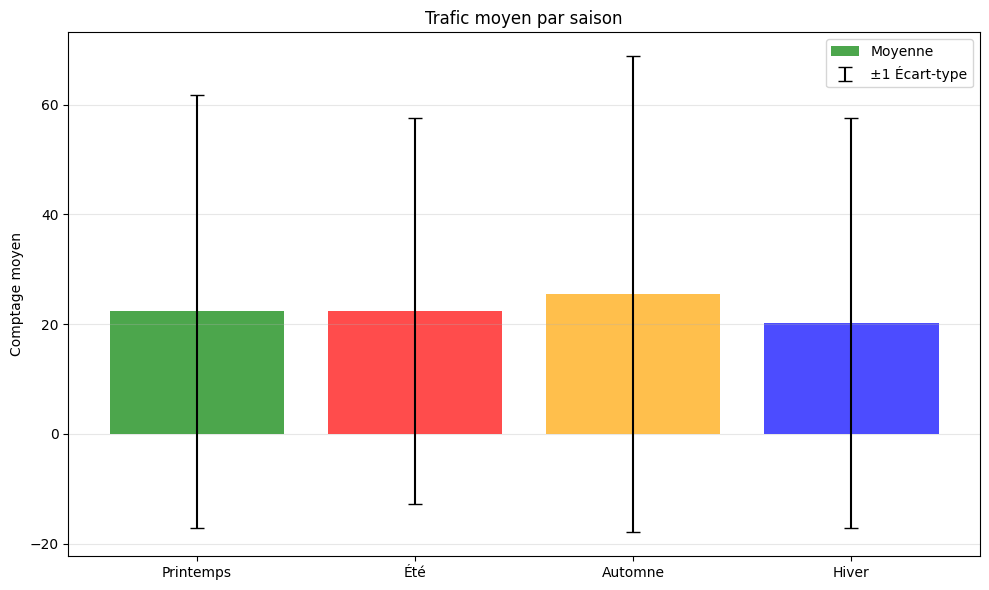


Statistiques par saison:
                mean        std  min    max
season                                     
Printemps  22.328929  39.416781  0.0  445.0
Été        22.334331  35.206051  0.0  456.0
Automne    25.430632  43.417339  0.0  512.0
Hiver      20.173316  37.366233  0.0  464.0


In [14]:
# Analyse saisonnière
df_brut["season"] = df_brut["time"].dt.month.apply(lambda x: 
    "Hiver" if x in [12, 1, 2] else
    "Printemps" if x in [3, 4, 5] else
    "Été" if x in [6, 7, 8] else
    "Automne")

fig, ax = plt.subplots(figsize=(10, 6))
seasonal_traffic = df_brut.groupby("season")["value"].agg(["mean", "std", "min", "max"])
seasonal_traffic = seasonal_traffic.reindex(["Printemps", "Été", "Automne", "Hiver"])

x_pos = range(len(seasonal_traffic))
ax.bar(x_pos, seasonal_traffic["mean"], color=["green", "red", "orange", "blue"], alpha=0.7, label="Moyenne")
ax.errorbar(x_pos, seasonal_traffic["mean"], yerr=seasonal_traffic["std"], fmt="none", color="black", capsize=5, label="±1 Écart-type")
ax.set_xticks(x_pos)
ax.set_xticklabels(seasonal_traffic.index)
ax.set_title("Trafic moyen par saison")
ax.set_ylabel("Comptage moyen")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

print("\nStatistiques par saison:")
print(seasonal_traffic)